<a id="top"></a>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Astrophysics</a> .
</div>

<a id="data-desc"></a>

<h1> Modelling Customer Churn using pycaret</h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

References
- [github:pycaret](https://github.com/pycaret)
- [TWS: PyCaret 2.2 is here — What’s new?](https://towardsdatascience.com/pycaret-2-2-is-here-whats-new-ad7612ca63b)
- [pycaret-demo-queens/PyCaret 2 Classification.ipynb](https://github.com/pycaret/pycaret-demo-queens/blob/main/PyCaret%202%20Classification.ipynb)

<a id="lib"></a>

<h1> Load the libraries </h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [187]:
import time

time_start_notebook = time.time()

In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
sns.set()
import joblib

from tqdm import tqdm_notebook as tqdm

SEED = 100
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly

# special
import pycaret

%load_ext watermark
%watermark -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
joblib    : 1.0.0
numpy     : 1.19.4
seaborn   : 0.11.0
pycaret   : 2.2.2
pandas    : 1.1.5
sys       : 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
matplotlib: 3.3.3



In [189]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # usual imports
    !pip install watermark
    !pip install scikit-plot

    # HPO for pycaret
    !pip install tune-sklearn
    !pip install optuna # hyperopt is already in colab

    # gpu version of lightgbm for pycaret
    !pip uninstall lightgbm -y
    !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

    # regular pycaret without gpu 
    !pip install pycaret-nightly[full]

    # ipywidget
    !pip install ipywidgets
    !jupyter nbextension enable --py widgetsnbextension

    from pycaret.utils import enable_colab
    enable_colab()

    print('Environment: Google Colab')

<a id="useful" ></a>

<h1> Useful Scripts </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [190]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

In [191]:
def compare_new_models(name,desc,mean_row,ofile,
                       df_eval=None,sort='Recall',show=True):
    """Create dataframe from output of pycaret new model.
    Parameters
    -----------
    name: str
        Name of the model. eg. xgboost
    desc: str
        Description of the model. e.g tuned,calibrated
    mean_arr: np.ndarray
        The mean row.
        e.g. 
        df_res = pyc.pull()
        mean_row = df_res.loc['Mean']
    ofile: str
        Output file name. e.g. 'pycaret_df_eval_lr.csv'
    df_eval: Pandas Dataframe
        Template pandas dataframe
    sort: str
       One of following string: Accuracy, AUC, Recall, Precision, F1, Kappa

    Returns:
       Pandas Dataframe.

    """
    
    if not isinstance(df_eval, pd.DataFrame):
        df_eval = pd.DataFrame({'Model': [],
                                'Description':[],
                                'Accuracy':[],
                                'AUC':[],
                                'Recall':[],
                                'Precision':[],
                                'F1':[],
                                'Kappa':[],
                                'MCC': [],
                                'LogLoss': []
                               })

    acc,auc,rec,pre,f1,kap,mcc,logloss = mean_row
    row = [name,desc,acc,auc,rec,pre,f1,kap,mcc,logloss]

    df_eval.loc[len(df_eval)] = row
    df_eval = df_eval.drop_duplicates()\
                     .sort_values(sort,ascending=False)
    df_eval.index = range(len(df_eval))
    
    df_style = (df_eval.style.apply(lambda ser:
                ['background: tomato'
                 if ser.name == sort else ''
                 for _ in ser]))

    if show:
        display(df_style)

    # save the data
    df_eval.to_csv(ofile,index=False)
    
    return df_eval

<a id="load-data" ></a>

<h1> Load the Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [192]:
path_data_train = '../data/processed/train_cleaned.csv'
path_data_test = '../data/processed/test_cleaned.csv'

if ENV_COLAB:
    path_data_train = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/processed/train_cleaned.csv'
    path_data_test = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/processed/test_cleaned.csv'

In [193]:
df_train = pd.read_csv(path_data_train)
df_test = pd.read_csv(path_data_test)

print(df_train.shape)
print(df_test.shape)
df_train.head(2).append(df_train.tail(2))

(5634, 39)
(1409, 39)


,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,NoSeniorCitizen_Contract_Month-to-month,PaymentMethod0_Contract_Month-to-month0,InternetService_Fiber optic,StreamingTV_NoInternetService,No_OB_DP_TS,TotalServices,SenCit_Dependents,Partner_Dependents,SenCit_Partner,SenCit_Contract,SenCit_TechSupport,SenCit_PayMeth,Contract_mean_totCharges,Contract_totCharges_diff,PayMeth_mean_monthCharges,PayMeth_monthCharges_diff,Tenure_cat,MonthlyCharges_cat
0,0,0,1,0,36,1,2,1,2,2,2,2,0,2,2,1,1,106.05,3834.40,0,1,0,0,0,1,1,2,0,1,1,2,2,1,3683.643192,150.756808,66.703657,39.346343,3,0
1,1,0,0,0,10,1,0,0,2,0,0,2,2,0,0,0,1,62.25,612.95,0,0,1,0,1,1,1,1,0,0,0,0,2,1,1370.923131,-757.973131,66.703657,-4.453657,0,0
5632,0,0,1,1,68,1,2,1,0,2,0,2,2,2,2,1,1,103.75,7039.45,0,1,0,0,0,1,1,2,1,2,1,2,2,1,3683.643192,3355.806808,66.703657,37.046343,5,0
5633,1,0,0,0,69,1,2,2,1,1,1,1,1,1,2,0,1,23.95,1713.10,0,1,0,0,1,0,1,7,0,0,0,2,1,1,3683.643192,-1970.543192,66.703657,-42.753657,5,0


In [194]:
target_name = 'Churn'

<a id="eda" ></a>

<h1> Data Processing  </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [195]:
# check for nans
df_train.isna().sum().sum()

0

<a id="" ></a>

<h1>  Modelling Pycaret </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [196]:
import pycaret
import pycaret.classification as pyc

<a id="" ></a>

<h1>  Pycaret Setup</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.setup(
    data: pandas.core.frame.DataFrame,
    target: str,
    train_size                    = 0.7,
    test_data                     = None,
    preprocess                    = True,
    imputation_type               = 'simple',
    iterative_imputation_iters    = 5,
    categorical_features          = None,
    categorical_imputation        = 'constant',
    categorical_iterative_imputer = 'lightgbm',
    ordinal_features              = None,
    high_cardinality_features     = None,
    high_cardinality_method       = 'frequency',
    numeric_features              = None,
    numeric_imputation            = 'mean',
    numeric_iterative_imputer     = 'lightgbm',
    date_features                 = None,
    ignore_features               = None,
    normalize                     = False,
    normalize_method              = 'zscore',
    transformation                = False,
    transformation_method         = 'yeo-johnson',
    handle_unknown_categorical    = True,
    unknown_categorical_method    = 'least_frequent',
    pca                           = False,
    pca_method                    = 'linear',
    pca_components                = None,
    ignore_low_variance           = False,
    combine_rare_levels           = False,
    rare_level_threshold          = 0.1,
    bin_numeric_features          = None,
    remove_outliers               = False,
    outliers_threshold            = 0.05,
    remove_multicollinearity      = False,
    multicollinearity_threshold   = 0.9,
    remove_perfect_collinearity   = True,
    create_clusters               = False,
    cluster_iter                  = 20,
    polynomial_features           = False,
    polynomial_degree             = 2,
    trigonometry_features         = False,
    polynomial_threshold          = 0.1,
    group_features                = None,
    group_names                   = None,
    feature_selection             = False,
    feature_selection_threshold   = 0.8,
    feature_selection_method      = 'classic',
    feature_interaction           = False,
    feature_ratio                 = False,
    interaction_threshold         = 0.01,
    fix_imbalance                 = False,
    fix_imbalance_method          = None,
    data_split_shuffle            = True,
    data_split_stratify           = False,
    fold_strategy                 = 'stratifiedkfold',
    fold                          = 10,
    fold_shuffle                  = False,
    fold_groups                   = None,
    n_jobs                        = -1,
    use_gpu                       = False,
    custom_pipeline               = None,
    html                          = True,
    session_id                    = None,
    log_experiment                = False,
    experiment_name               = None,
    log_plots                     = False,
    log_profile                   = False,
    log_data                      = False,
    silent                        = False,
    verbose                       = True,
    profile                       = False,
    profile_kwargs                = None,
)

```

In [197]:
df_train.shape

(5634, 39)

In [198]:
show_methods(pyc)

,0,1,2,3
0,Any,calibrate_model,interpret_model,pull
1,Dict,compare_models,io,pycaret
2,Display,create_model,is_in_colab,remove_metric
3,List,deploy_model,load_config,save_config
4,MLUsecase,enable_colab,load_model,save_model
5,Optional,ensemble_model,models,set_config
6,Tuple,evaluate_model,np,setup
7,Union,finalize_model,optimize_threshold,stack_models
8,add_metric,get_config,pd,traceback
9,automl,get_logs,plot_model,tune_model


In [199]:
USE_GPU = False
if ENV_COLAB:
    USE_GPU = True

In [200]:
exp = pyc.setup(df_train,target_name,
                train_size=0.8,
                session_id=SEED,
                use_gpu=USE_GPU,
                preprocess = True,
                categorical_features = None,
                ordinal_features = None,
                high_cardinality_features = None,
                numeric_features = None,
                date_features = None,
                ignore_features = None,
                normalize = False,
                data_split_stratify = True,
                silent=True,
                profile=False,
                log_experiment=False
                )

# use silent = True to check inferred datatypes
# then assign numeric and categorical features yourself.
#
# if sampling = False, 100% of data is used and its too slow
# if sampling = True, we need to enter number eg. 0.3 ourself.

"""
Here, we have data < 25k rows, so I have chosen not to use sampling.

""";

,Description,Value
0,session_id,100
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5634, 39)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,32
8,Ordinal Features,False
9,High Cardinality Features,False


In [201]:
pyc.models(internal=True)[['Name', 'GPU Enabled']]

,Name,GPU Enabled
ID,,
lr,Logistic Regression,False
knn,K Neighbors Classifier,False
nb,Naive Bayes,False
dt,Decision Tree Classifier,False
svm,SVM - Linear Kernel,False
rbfsvm,SVM - Radial Kernel,False
gpc,Gaussian Process Classifier,False
mlp,MLP Classifier,False
ridge,Ridge Classifier,False


<a id="" ></a>

<h1>  Comparing Models </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>



Comparing All Models
- compare using stratified cross validation for metric evaluation.
- shows average metrics for score grid for 10 fold cross-validation
- default sorting is `accuracy`


```python
pyc.compare_models(
    include          = None,
    exclude          = None,
    fold             = None,
    round            = 4,
    cross_validation = True,
    sort             = 'Accuracy',
    n_select         = 1,
    budget_time      = None,
    turbo            = True,
    errors           = 'ignore',
    fit_kwargs       = None,
    groups           = None,
    verbose          = True,
) 
```


In [202]:
# pyc.compare_models?

In [203]:
pyc.get_metrics().index

Index(['acc', 'auc', 'recall', 'precision', 'f1', 'kappa', 'mcc'], dtype='object', name='ID')

In [204]:
# add Log Loss metric in pycaret
from sklearn.metrics import log_loss
pyc.add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False)

Name                                                        LogLoss
Display Name                                                LogLoss
Score Function                <function log_loss at 0x7fad8abb88b0>
Scorer               make_scorer(log_loss, greater_is_better=False)
Target                                                         pred
Args                                                             {}
Greater is Better                                             False
Multiclass                                                     True
Custom                                                         True
Name: logloss, dtype: object

In [205]:
best = pyc.compare_models(sort = 'Recall',fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
nb,Naive Bayes,0.7069,0.8243,0.8345,0.4722,0.6027,0.3983,0.4389,10.1234,0.0400
qda,Quadratic Discriminant Analysis,0.6102,0.6244,0.6548,0.3697,0.4717,0.2001,0.2210,13.4642,0.0460
lda,Linear Discriminant Analysis,0.8107,0.8455,0.5493,0.6780,0.6067,0.4839,0.4887,6.5368,0.0500
gbc,Gradient Boosting Classifier,0.8123,0.8496,0.5418,0.6861,0.6053,0.4843,0.4903,6.4831,0.5160
ada,Ada Boost Classifier,0.8107,0.8498,0.5402,0.6840,0.6028,0.4808,0.4872,6.5368,0.1800
lr,Logistic Regression,0.8063,0.8507,0.5376,0.6684,0.5957,0.4703,0.4753,6.6900,0.7700
lightgbm,Light Gradient Boosting Machine,0.7959,0.8345,0.5326,0.6401,0.5808,0.4475,0.4512,7.0502,1.1780
catboost,CatBoost Classifier,0.8028,0.8437,0.5318,0.6612,0.5888,0.4611,0.4663,6.8127,4.5100
xgboost,Extreme Gradient Boosting,0.7854,0.8250,0.5301,0.6106,0.5672,0.4256,0.4276,7.4104,0.8720
rf,Random Forest Classifier,0.7972,0.8258,0.5109,0.6512,0.5723,0.4419,0.4477,7.0041,0.2960


In [206]:
# pyc.get_logs() # only works if we set log expt as true

<a id="" ></a>

<h1>  Create Models </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```
Estimator                   Abbreviated String     Original Implementation 
---------                   ------------------     -------------------------------
Logistic Regression         'lr'                   linear_model.LogisticRegression
K Nearest Neighbour         'knn'                  neighbors.KNeighborsClassifier
Naives Bayes                'nb'                   naive_bayes.GaussianNB
Decision Tree               'dt'                   tree.DecisionTreeClassifier
SVM (Linear)                'svm'                  linear_model.SGDClassifier
SVM (RBF)                   'rbfsvm'               svm.SVC
Gaussian Process            'gpc'                  gaussian_process.GPC
Multi Level Perceptron      'mlp'                  neural_network.MLPClassifier
Ridge Classifier            'ridge'                linear_model.RidgeClassifier
Random Forest               'rf'                   ensemble.RandomForestClassifier
Quadratic Disc. Analysis    'qda'                  discriminant_analysis.QDA
AdaBoost                    'ada'                  ensemble.AdaBoostClassifier
Gradient Boosting           'gbc'                  ensemble.GradientBoostingClassifier
Linear Disc. Analysis       'lda'                  discriminant_analysis.LDA
Extra Trees Classifier      'et'                   ensemble.ExtraTreesClassifier
Extreme Gradient Boosting   'xgboost'              xgboost.readthedocs.io
Light Gradient Boosting     'lightgbm'             github.com/microsoft/LightGBM
CatBoost Classifier         'catboost'             https://catboost.ai
```

```python
pyc.create_model(
    estimator,
    fold             = None,
    round            = 4,
    cross_validation = True,
    fit_kwargs       = None,
    groups           = None,
    verbose          = True,
    **kwargs,
)
```

In [207]:
model_name = 'lr'
path_df_eval = 'pycaret_df_eval_lr.csv'

lr = pyc.create_model(model_name,verbose=False)
mean_row = pyc.pull().loc['Mean']
df_eval = compare_new_models('lr','default',mean_row,path_df_eval,
                             sort='Recall',df_eval=None)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,lr,default,0.805600,0.849100,0.531800,0.669900,0.592200,0.466900,0.472700,6.713100


In [208]:
model_name = 'xgboost'
xgb = pyc.create_model(model_name,verbose=False)
mean_row = pyc.pull().loc['Mean']
df_eval = compare_new_models(model_name,'default',mean_row,
                path_df_eval,sort='Recall',df_eval=df_eval)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,lr,default,0.805600,0.849100,0.531800,0.669900,0.592200,0.466900,0.472700,6.713100
1,xgboost,default,0.788600,0.826500,0.518500,0.621700,0.565100,0.427000,0.430300,7.303000


In [209]:
model_name = 'lightgbm'
lgb = pyc.create_model(model_name,verbose=False)

mean_row = pyc.pull().loc['Mean']
df_eval = compare_new_models(model_name,'default',
            mean_row,path_df_eval,sort='Recall',df_eval=df_eval)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,lr,default,0.805600,0.849100,0.531800,0.669900,0.592200,0.466900,0.472700,6.713100
1,lightgbm,default,0.792800,0.835600,0.527700,0.631300,0.574200,0.438900,0.442400,7.157400
2,xgboost,default,0.788600,0.826500,0.518500,0.621700,0.565100,0.427000,0.430300,7.303000


In [210]:
nb = pyc.create_model('nb',verbose=False)

mean_row = pyc.pull().loc['Mean']
df_eval = compare_new_models('nb','default',
            mean_row,path_df_eval,sort='Recall',df_eval=df_eval)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,nb,default,0.706000,0.824100,0.833600,0.471200,0.601600,0.396700,0.437300,10.154100
1,lr,default,0.805600,0.849100,0.531800,0.669900,0.592200,0.466900,0.472700,6.713100
2,lightgbm,default,0.792800,0.835600,0.527700,0.631300,0.574200,0.438900,0.442400,7.157400
3,xgboost,default,0.788600,0.826500,0.518500,0.621700,0.565100,0.427000,0.430300,7.303000


<a id="" ></a>

<h1>  Hyperparameter Tuning</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.tune_model(
    estimator,
    fold                     = None,
    round                    = 4,
    n_iter                   = 10,
    custom_grid              = None,
    optimize                 = 'Accuracy',
    custom_scorer            = None,
    search_library           = 'scikit-learn', # 'scikit-optimize', 'tune-sklearn','optuna'
    search_algorithm         = None, # 'scikit-learn', 'scikit-optimize', 'tune-sklearn', 'optuna'
    early_stopping           = False, # 'asha','hyperband','median' 
    early_stopping_max_iters = 10,
    choose_better            = False,
    fit_kwargs               = None,
    groups                   = None,
    return_tuner             = False,
    verbose                  = True,
    tuner_verbose            = True,
    **kwargs,
)
```

In [211]:
# lr_tuned1 = pyc.tune_model(lr,fold=5,optimize='Recall',
#                           search_library='scikit-optimize',verbose=False)

# mean_row = pyc.pull().loc['Mean']
# df_eval = compare_new_models('lr','tuned,scikit-optimize',
#              mean_row,path_df_eval,sort='Recall',df_eval=df_eval)

In [212]:
# lr_tuned2 = pyc.tune_model(lr,fold=5,optimize='Recall',
#                           search_library='tune-sklearn',verbose=False)

# mean_row = pyc.pull().loc['Mean']
# df_eval = compare_new_models('lr','tuned,tune-sklearn',
#    mean_row,path_df_eval,sort='Recall',df_eval=df_eval)

In [213]:
# %%capture
# # use capture, there are too many lines of
# # The `start_trial` operation took 0.67942214012146 seconds to complete, which may be a performance bottleneck.
# lr_tuned3 = pyc.tune_model(lr,fold=5,optimize='Recall',
#             search_library='tune-sklearn',n_iter=100,
#                            verbose=False,tuner_verbose=False)

# mean_row = pyc.pull().loc['Mean']
# desc = 'tuned,tune-sklearn,n_iter=100'
# df_eval = compare_new_models('lr',desc,mean_row,path_df_eval,sort='Recall',df_eval=df_eval)

In [214]:
# %%capture
# # optimize f1
# lr_tuned4 = pyc.tune_model(lr,fold=5,optimize='F1',
#             search_library='tune-sklearn',n_iter=100, verbose=False)

# mean_row = pyc.pull().loc['Mean']
# desc = 'tuned,tune-sklearn,n_iter=100,optimize=F1'
# df_eval = compare_new_models('lr',desc,mean_row,path_df_eval,sort='Recall',df_eval=df_eval)

In [215]:
# %%time
# lr_tuned4 = pyc.tune_model(lr,fold=5,optimize='Recall',
#             search_library='tune-sklearn',
#             n_iter=500,
#             early_stopping='asha',
#             early_stopping_max_iters=10,
#             verbose=True)

# this did not improve recall or f1

In [216]:
# from sklearn.linear_model import LogisticRegression
# lr_tuned5 = LogisticRegression(C=6.669, class_weight={}, dual=False, fit_intercept=True,
#                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
#                    multi_class='auto', n_jobs=None, penalty='l2',
#                    random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
#                    warm_start=False)

In [217]:
# # tune hyperparameters with custom_grid
# params_lr = {"C": [2.039,0],
#           "penalty": ["l1", "l2"]
#           }

# tuned_lr_custom = pyc.tune_model(lr, custom_grid = params_lr,verbose=False)
# mean_row = pyc.pull().loc['Mean']
# desc = 'tuned,custom_grid'
# df_eval = compare_new_models('lr',desc,mean_row,path_df_eval,sort='Recall',df_eval=df_eval)

In [218]:
# look at df_eval and choose best model
# df_eval

In [219]:
# model_best = lr_tuned3
# print(model_best)

"""
LogisticRegression(C=2.235, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

""";

<a id="" ></a>

<h1>  Save Model After HPO </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [220]:
odir = '.' if ENV_COLAB else '../models/'
path_model_best = odir+'pycaret_model_best_lr.joblib'

# joblib.dump(model_best, path_model_best)

In [221]:
model_best = joblib.load(path_model_best)
model_best

LogisticRegression(C=5.765, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<a id="" ></a>

<h1>  Model Calibration</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.calibrate_model(
    estimator,
    method     = 'sigmoid',
    fold       = None,
    round      = 4,
    fit_kwargs = None,
    groups     = None,
    verbose    = True,
)
```

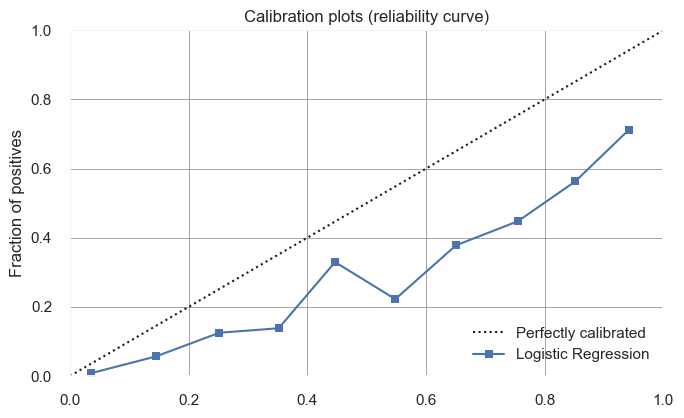

In [222]:
pyc.plot_model(model_best, plot='calibration')

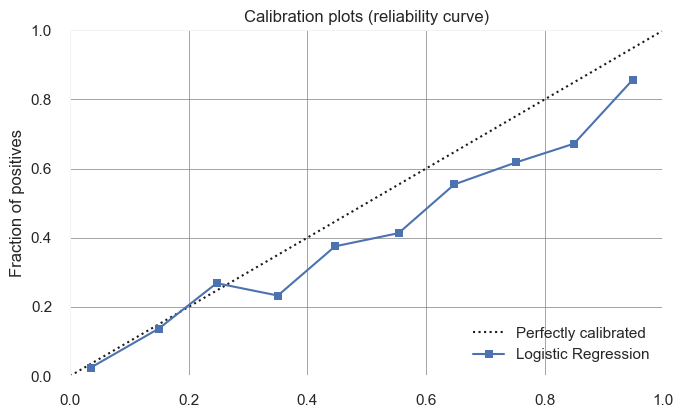

In [223]:
model_best_tuned_calibrated = pyc.calibrate_model(model_best,fold=5,
                                            method='sigmoid',verbose=False)

mean_row = pyc.pull().loc['Mean']
desc = 'tuned+calibrated'
df_eval = compare_new_models('lr',desc,mean_row,
                             path_df_eval,sort='Recall',df_eval=df_eval)
pyc.plot_model(model_best_tuned_calibrated, plot='calibration')

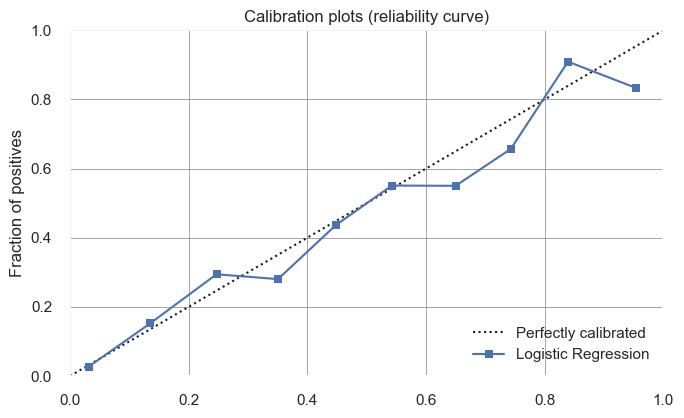

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,nb,default,0.706000,0.824100,0.833600,0.471200,0.601600,0.396700,0.437300,10.154100
1,lr,default,0.805600,0.849100,0.531800,0.669900,0.592200,0.466900,0.472700,6.713100
2,lightgbm,default,0.792800,0.835600,0.527700,0.631300,0.574200,0.438900,0.442400,7.157400
3,lr,tuned+calibrated,0.805900,0.849800,0.527600,0.671900,0.590800,0.465900,0.472000,6.705400
4,lr,tuned+calibrated_iso,0.805900,0.850000,0.525100,0.674200,0.589900,0.465300,0.471800,6.705300
5,xgboost,default,0.788600,0.826500,0.518500,0.621700,0.565100,0.427000,0.430300,7.303000


In [224]:
model_best_tuned_calibrated_iso = pyc.calibrate_model(model_best,
                            fold=5, method='isotonic',verbose=False)

pyc.plot_model(model_best_tuned_calibrated_iso, plot='calibration')
mean_row = pyc.pull().loc['Mean']
desc = 'tuned+calibrated_iso'
df_eval = compare_new_models('lr',desc,mean_row,
            path_df_eval,sort='Recall',df_eval=df_eval)

<a id="" ></a>

<h1>  Save Model After Calibration </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [225]:
model_best = model_best # calibration did not gave better model


# odir = '.' if ENV_COLAB else '../models/'
# path_model_best = odir+'pycaret_model_best_nb.joblib'
# path_model_best_F1 = odir+'pycaret_model_best_F1_nb.joblib'

# # joblib.dump(model_best, path_model_best)
# # joblib.dump(model_best_F1, path_model_best_F1)


# model_best = joblib.load(path_model_best)
# model_best_F1 = joblib.load(path_model_best_F1)

<a id="" ></a>

<h1>  Model Evaluation (Validation) : plot_model and evaluate_model </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```
Abbreviated String     Name
------------------     -------
* 'auc'                - Area Under the Curve
* 'threshold'          - Discrimination Threshold
* 'pr'                 - Precision Recall Curve
* 'confusion_matrix'   - Confusion Matrix
* 'error'              - Class Prediction Error
* 'class_report'       - Classification Report
* 'boundary'           - Decision Boundary
* 'rfe'                - Recursive Feature Selection
* 'learning'           - Learning Curve
* 'manifold'           - Manifold Learning
* 'calibration'        - Calibration Curve
* 'vc'                 - Validation Curve
* 'dimension'          - Dimension Learning
* 'feature'            - Feature Importance
* 'feature_all'        - Feature Importance (All)
* 'parameter'          - Model Hyperparameter
* 'lift'               - Lift Curve
* 'gain'               - Gain Chart
* 'tree'               - Decision Tree
```

```python
pyc.plot_model(
    estimator,
    plot           = 'auc',
    scale          = 1,
    save           = False,
    fold           = None,
    fit_kwargs     = None,
    groups         = None,
    use_train_data = False, # if true, train data will be used for not test
    verbose        = True,
)
```

```python
pyc.evaluate_model(
    estimator,
    fold           = None,
    fit_kwargs     = None,
    groups         = None,
    use_train_data = False,
)
```

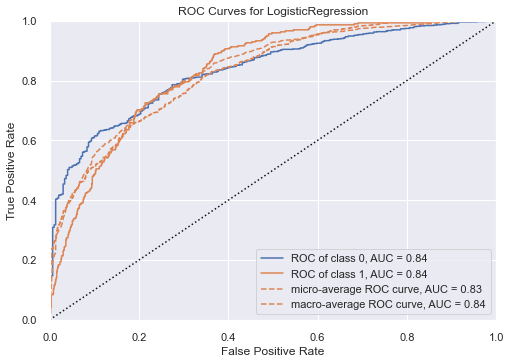

In [226]:
# AUC-ROC plot
pyc.plot_model(model_best, plot = 'auc')

In [227]:
# evaluate model (click on buttotns to see the plots)
pyc.evaluate_model(model_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

<a id="" ></a>

<h1>  Model Interpretation of Tree Methods (Validation) </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.interpret_model(
    estimator,
    plot           = 'summary',
    feature        = None,
    observation    = None,
    use_train_data = False,
    **kwargs,
)
```

- not supported models: logistic regression, nb
- supported models : rf, xgboost, lightgbm, catboost, dt, et

In [228]:
# pyc.interpret_model?

In [229]:
# interpret_model: SHAP
# pyc.interpret_model(model_best)

# note: logistic regression is not supported
# supported: rf, xgboost, lightgbm, catboost, dt, et

In [230]:
# interpret model : Correlation
# pyc.interpret_model(model_best_lr,plot='correlation')

In [231]:
# interpret model : Reason
# pyc.interpret_model(model_best_lr,plot='reason',obervation=12)

<a id="" ></a>

<h1>  Pycaret configs </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
    - X: Transformed dataset (X)
    - y: Transformed dataset (y)  
    - X_train: Transformed train dataset (X)
    - X_test: Transformed test/holdout dataset (X)
    - y_train: Transformed train dataset (y)
    - y_test: Transformed test/holdout dataset (y)
    - seed: random state set through session_id
    - prep_pipe: Transformation pipeline
    - fold_shuffle_param: shuffle parameter used in Kfolds
    - n_jobs_param: n_jobs parameter used in model training
    - html_param: html_param configured through setup
    - create_model_container: results grid storage container
    - master_model_container: model storage container
    - display_container: results display container
    - exp_name_log: Name of experiment
    - logging_param: log_experiment param
    - log_plots_param: log_plots param
    - USI: Unique session ID parameter
    - fix_imbalance_param: fix_imbalance param
    - fix_imbalance_method_param: fix_imbalance_method param
    - data_before_preprocess: data before preprocessing
    - target_param: name of target variable
    - gpu_param: use_gpu param configured through setup
    - fold_generator: CV splitter configured in fold_strategy
    - fold_param: fold params defined in the setup
    - fold_groups_param: fold groups defined in the setup
    - stratify_param: stratify parameter defined in the setup
```

In [232]:
# help(pyc.get_config)

In [233]:
df_train.shape, pyc.get_config('X_test').shape # we have ohe columns.

((5634, 39), (1127, 60))

<a id="" ></a>

<h1>  Finalize model (Fit whole train data) </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.finalize_model(
    estimator,
    fit_kwargs = None,
    group      = None,
    model_only = True,
)

Docstring:
This function trains a given estimator on the entire dataset including the 
holdout set.
```

In [234]:
# pyc.finalize_model?

In [235]:
model_final = pyc.finalize_model(model_best)
print(model_final)

LogisticRegression(C=5.765, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


<a id="" ></a>

<h1>  Model Evaluation on Test Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [236]:
df_preds = pyc.predict_model(model_final,df_test)
df_preds.iloc[-5:,-5:]

,PayMeth_monthCharges_diff,Tenure_cat,MonthlyCharges_cat,Label,Score
1404,16.585135,0,0,1,0.7454
1405,-19.764865,3,0,0,0.8145
1406,6.085135,1,0,1,0.7362
1407,30.735135,1,0,1,0.8607
1408,-2.787658,1,0,1,0.5231


In [237]:
ytest = df_preds[target_name].to_numpy().ravel()
yprobs = df_preds['Score'].to_numpy().ravel()
ypreds = df_preds['Label'].to_numpy().ravel()

yprobs2d = np.c_[1-yprobs,yprobs]

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1035
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409

[[750 285]
 [ 76 298]]


,Accuracy,Precision,Recall,F1-score,AUC
pycaret_lr,0.7438,0.5111,0.7968,0.6228,0.7607


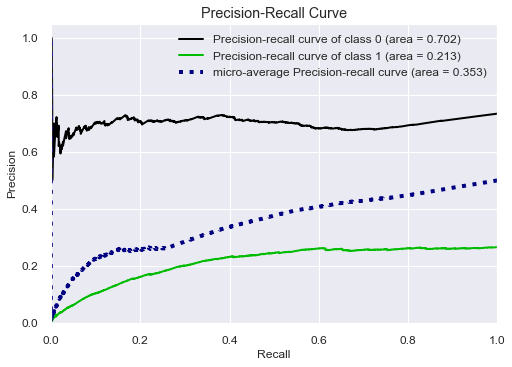

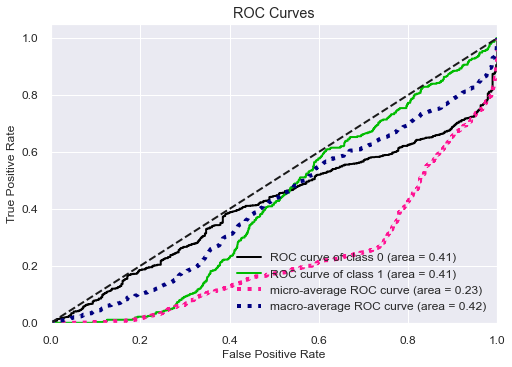

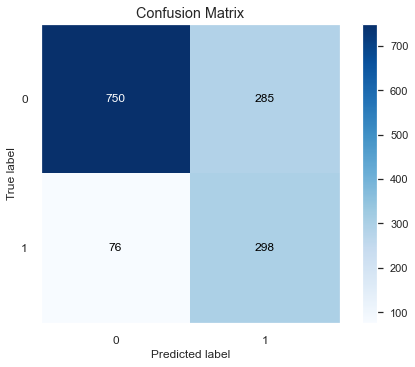

In [238]:
def model_eval_bin(model_name,ytest,ypreds,yprobs2d,show_plots=True):
    import sklearn.metrics as skmetrics
    import scikitplot.metrics as skpmetrics
    import os

    acc       = skmetrics.accuracy_score(ytest,ypreds)
    precision = skmetrics.precision_score(ytest,ypreds)
    recall    = skmetrics.recall_score(ytest,ypreds)
    f1        = skmetrics.f1_score(ytest,ypreds)
    auc       = skmetrics.roc_auc_score(ytest,ypreds)

    print(skmetrics.classification_report(ytest,ypreds))
    print(skmetrics.confusion_matrix(ytest,ypreds))

    df_res = pd.DataFrame({'Accuracy':[acc],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1-score': [f1],
                          'AUC': [auc]},index=[model_name])

    display(df_res.style.format("{:.4f}"))
    if not os.path.isdir('../outputs'):
        os.makedirs('../outputs')
    o = '.' if ENV_COLAB else '../outputs/'
    df_res.to_csv(o+f'model_{model_name}.csv',index=True)

    if show_plots:
        skpmetrics.plot_precision_recall(ytest,yprobs2d) # more focus on minority
        skpmetrics.plot_roc_curve(ytest,yprobs2d) # equal focus on both groups
        skpmetrics.plot_confusion_matrix(ytest,ypreds)

model_eval_bin('pycaret_lr',ytest,ypreds,yprobs2d,show_plots=True)

In [239]:
df_preds[target_name].value_counts()

0    1035
1     374
Name: Churn, dtype: int64

In [240]:
df_preds[target_name].value_counts(normalize=True)

0    0.734564
1    0.265436
Name: Churn, dtype: float64

<a id="" ></a>

<h1>  Time Taken </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [242]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 1 min 53 secs
